In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cftime
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import pearsonr, kendalltau, spearmanr

# Prices Ljunqgvist

In [ ]:
oats = pd.read_excel('..data/Grain_prices_series_Ljungqvist_and_Seim.xlsx', sheet_name='Oats').dropna(axis=0, how='all')
wheat = pd.read_excel('..data/Grain_prices_series_Ljungqvist_and_Seim.xlsx', sheet_name='Wheat').dropna(axis=0, how='all')
barley = pd.read_excel('..data/Grain_prices_series_Ljungqvist_and_Seim.xlsx', sheet_name='Barley').dropna(axis=0, how='all')
rye = pd.read_excel('..data/Grain_prices_series_Ljungqvist_and_Seim.xlsx', sheet_name='Rye').dropna(axis=0, how='all')


In [3]:
locations = oats.columns[1:]  # Skip the 'Place' column
latitudes = oats.iloc[1, 1:]
longitudes = oats.iloc[0, 1:]

# Create a new DataFrame from the 4th row (index 3, which is Year) onwards
values_df = oats.iloc[3:].copy()
values_df.columns = oats.columns
values_df = values_df.drop(columns="Place")

# Reshape the values to long format
melted = values_df.melt(var_name="Location", value_name="Price")
melted["Year"] = oats.columns[0]  # This would be '1500' from row index 3
melted["Latitude"] = melted["Location"].map(latitudes)
melted["Longitude"] = melted["Location"].map(longitudes)

# Reorder columns
final_df = melted[["Year", "Location", "Latitude", "Longitude", "Price"]]

# Convert Year to int
final_df["Year"] = int(oats.iloc[3, 0])

In [4]:
def reshape_crop_df(df, crop_name):
    # Extract lat/lon
    locations = df.columns[1:]
    longitudes = df.iloc[0, 1:]
    latitudes = df.iloc[1, 1:]
    
    # Extract data rows (starting after latitude row)
    data_rows = df.iloc[3:].copy()
    data_rows.columns = df.columns

    # Melt into long format
    melted = data_rows.melt(id_vars="Place", var_name="Location", value_name="Price")
    melted["Year"] = melted["Place"].astype(int)
    melted["Latitude"] = melted["Location"].map(latitudes)
    melted["Longitude"] = melted["Location"].map(longitudes)
    melted["Grain"] = crop_name

    return melted[["Grain", "Year", "Location", "Latitude", "Longitude", "Price"]].dropna(subset=["Price"])

# Example: process all four crops
oats_df = reshape_crop_df(oats, "Oats")
rye_df = reshape_crop_df(rye, "Rye")
wheat_df = reshape_crop_df(wheat, "Wheat")
barley_df = reshape_crop_df(barley, "Barley")

# Combine into one DataFrame
combined_df = pd.concat([oats_df, rye_df, wheat_df, barley_df], ignore_index=True)
combined_df['Price'] = combined_df['Price'].astype(float)

In [5]:

#average all the grain prices for same year and location
avg_df = combined_df.drop('Grain', axis=1).groupby(['Year', 'Location', 'Latitude', 'Longitude']).mean().reset_index()

#divide brussels prices by 100
avg_df.loc[avg_df['Location'] == 'Brussels', 'Price'] /= 100


In [6]:
avg_df.describe()

,Year,Latitude,Longitude,Price
count,11842.000000,11842.000000,11842.000000,11842.000000
mean,1655.859737,47.879788,4.557902,0.523354
std,81.769091,4.261250,6.290508,0.313026
min,1500.000000,38.570000,-9.140000,0.028084
25%,1588.000000,45.170000,-0.130000,0.302434
50%,1657.000000,48.850000,4.900000,0.456928
75%,1726.000000,51.050000,8.540000,0.682796
max,1800.000000,54.370000,18.630000,3.992126


In [7]:
avg_df['Location'].unique()
#print number of years per location
avg_df.groupby('Location').size().sort_values(ascending=False)

print(avg_df['Location'].unique().shape)

(46,)


In [8]:
#turn into wide format
df_wide = avg_df.pivot_table(index=['Year'], columns='Location', values='Price')

In [9]:
#remove England and South England fron avvg_df 
avg_df = avg_df[~avg_df['Location'].isin(['England', 'Southern England'])]

In [10]:
avg_df.Location.unique()

array(['Amsterdam', 'Augsburg', 'Cambridge', 'Douai', 'Exeter',
       'Frankfurt', 'Ghent', 'Leiden', 'Lisbon', 'London', 'Munich',
       'Paris', 'Strasbourg', 'Toulouse', 'Tours', 'Utrecht', 'Valencia',
       'Würzburg', 'Xanten', 'Barcelona', 'Basle', 'Bassano del Grappa',
       'Brussels', 'Gdansk', 'Grenoble', 'Madrid', 'Wels', 'Coimbra ',
       'New Castile', 'Évora', 'Speyer', 'Vienna', 'Aachen', 'Cologne',
       'Zürich', 'Siena', 'Pisa', 'Naples', 'Oxford', 'Leipzig', 'Arnhem',
       'Avignon', 'Düren', 'Angers'], dtype=object)

# PDSI

In [11]:
lat_lon_dict = {}
for i, row in avg_df.iterrows():
    lat_lon_dict[row['Location']] = (row['Latitude'], row['Longitude'])

In [12]:
# # Load dataset
# owda = xr.open_dataset("data/owda.nc")

# # Compute latitude-weighted PDSI
# owda["PDSI_weighted"] = np.sqrt(np.cos(np.deg2rad(owda["lat"])) + 1e-6) * owda["pdsi"]

# # Compute European domain-average PDSI
# pdsi_europe = owda["PDSI_weighted"].sel(lat=slice(35, 70), lon=slice(-10, 40)).mean(dim=["lat", "lon"])



# # Store results in a list
# selected_data = []

# tol_lat = 2
# tol_lon = 2
# for city, (city_lat, city_lon) in lat_lon_dict.items():
#     # Select all points within a tol°×tol° box
#     if tol_lat == 0.:
#         lat_range = city_lat
#     else:

#         lat_range = slice(city_lat - tol_lat, city_lat + tol_lat)
#     if tol_lon == 0.:
#         lon_range = city_lon
#     else:
#         lon_range = slice(city_lon - tol_lon, city_lon + tol_lon)

#     if tol_lat == 0. and tol_lon == 0.:
#         city_data = owda.sel(lat=city_lat, lon=city_lon, method="nearest")
#     else:
#         city_data = owda.sel(lat=lat_range, lon=lon_range)

#     # Check if selection is valid (avoid NaNs)
#     if not city_data["PDSI_weighted"].isnull().all():
#         if tol_lat == 0. and tol_lon == 0.:
#             city_avg = city_data
#         else:
#             city_avg = city_data.mean(dim=["lat", "lon"])
#         city_avg = city_avg.assign_coords(Location=city)
#         selected_data.append(city_avg)

# # Concatenate all cities
# pdsi_selected = xr.concat(selected_data, dim="Location")

# # Rename "time" to "Year" and add European PDSI
# pdsi_selected = pdsi_selected.assign(PDSI_europe=pdsi_europe)
# pdsi_selected = pdsi_selected.rename({"time": "Year"})



# # Convert to DataFrame
# pdsi_df = pdsi_selected[["PDSI_weighted", "PDSI_europe"]].to_dataframe().reset_index()
# pdsi_df.rename(columns={"PDSI_weighted": "PDSI"}, inplace=True)
# pdsi_df['loc_id'] = pdsi_df['Location']


In [ ]:
# Load OWDA and compute weighted PDSI
owda = xr.open_dataset("..data/owda.nc")
owda["PDSI_weighted"] = np.sqrt(np.cos(np.deg2rad(owda["lat"])) + 1e-6) * owda["pdsi"]

# Flatten the 3D (time, lat, lon) data into a long table of gridpoints
pdsi_grid = owda["PDSI_weighted"].stack(points=("lat", "lon")).reset_coords()

# Drop points where all values are NaN
valid_points = pdsi_grid.dropna(dim="points", how="all")

# Extract coordinates for KDTree
grid_coords = np.column_stack([valid_points["lat"].values, valid_points["lon"].values])
tree = cKDTree(grid_coords)

# Prepare city coordinates
city_coords = np.array(list(lat_lon_dict.values()))  # shape (n_cities, 2)


radius = 1
# Query the nearest 'radius' grid points
distances, indices = tree.query(city_coords, k=1, workers=-1)

# Collect city-level time series
selected_data = []
years = owda["time"].values

for i, (city, coord) in enumerate(lat_lon_dict.items()):
    if radius == 0:
        grid_idx = indices[i]
        lat = valid_points["lat"].values[grid_idx]
        lon = valid_points["lon"].values[grid_idx]
        city_ts = owda["PDSI_weighted"].sel(lat=lat, lon=lon, method="nearest")
    else:
        # grid_idxs = indices[i]
        # lats = valid_points["lat"].values[grid_idxs]
        # lons = valid_points["lon"].values[grid_idxs]
        # ts_list = [owda["PDSI_weighted"].sel(lat=lat, lon=lon, method="nearest")
        #            for lat, lon in zip(lats, lons)]
        # city_ts = xr.concat(ts_list, dim="points").mean(dim="points")

        lat0, lon0 = coord
        lat_mask = (valid_points["lat"] >= lat0 - radius) & (valid_points["lat"] <= lat0 + radius)
        lon_mask = (valid_points["lon"] >= lon0 - radius) & (valid_points["lon"] <= lon0 + radius)
        selected = valid_points.where(lat_mask & lon_mask, drop=True)

        if selected.points.size == 0:
            print(f"No grid points found for city {city} within {radius}° radius.")
            continue

        ts_list = [
            owda["PDSI_weighted"].sel(lat=lat.item(), lon=lon.item(), method="nearest")
            for lat, lon in zip(selected["lat"].values, selected["lon"].values)
        ]
        city_ts = xr.concat(ts_list, dim="points").mean(dim="points")

    # Drop lat/lon coords to prevent merge conflicts
    city_ts = city_ts.drop_vars(["lat", "lon"], errors="ignore")
    city_ts = city_ts.expand_dims(Location=[city])  # assign city id
    selected_data.append(city_ts)

# Combine the city time series (DataArrays) into a Dataset
pdsi_selected = xr.Dataset({
    'PDSI': xr.concat(selected_data, dim="Location")
})

# Rename time to Year
pdsi_selected = pdsi_selected.rename({"time": "Year"})

# Add domain averages as DataArrays (with the same time/Year dimension)
pdsi_selected["PDSI_europe"] = owda["PDSI_weighted"].sel(lat=slice(35, 70), lon=slice(-10, 40)).mean(dim=["lat", "lon"]).rename({"time": "Year"})
pdsi_selected["PDSI_southern"] = owda["PDSI_weighted"].sel(lat=slice(20, 40), lon=slice(-10, 20)).mean(dim=["lat", "lon"]).rename({"time": "Year"})

pdsi_df = pdsi_selected.to_dataframe().reset_index()
pdsi_df.rename(columns={"PDSI_weighted": "PDSI"}, inplace=True)
#pdsi_df['loc_id'] = pdsi_df['Location']

# Temp

In [14]:
start = 1500
end = 1800

In [ ]:
# Load dataset
xds = xr.open_dataset('..data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds = xds.assign(Year=xds.time.dt.year)
xds = xds.sel(time=slice(str(start), str(end)))

# Apply latitude weighting
xds['temp'] = np.sqrt(np.cos(np.deg2rad(xds['latitude'])) + 1e-6) * (xds['temp2'])

# Define seasons
winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds = xds.assign_coords(time=("time", shift_decembers(xds.time.values)))



# --- **(1) Compute City-Level Temperatures** ---
def extract_location_data(xds_season):
    return [
        xds_season.sel(latitude=lat, longitude=lon, method='nearest')
        .to_dataframe().reset_index().assign(Location=city)
        for city, (lat, lon) in lat_lon_dict.items()
    ]

# Compute city-level seasonal means
xds_winter_cities = xds.sel(time=xds.time.dt.month.isin(winter_months)).groupby('Year').mean(dim='time')
xds_summer_cities = xds.sel(time=xds.time.dt.month.isin(summer_months)).groupby('Year').mean(dim='time')

temp_winter = pd.concat(extract_location_data(xds_winter_cities), ignore_index=True)
temp_summer = pd.concat(extract_location_data(xds_summer_cities), ignore_index=True)

# --- **(2) Compute European Domain-Average Temperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_europe = xds.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

# Function to compute spatially averaged seasonal mean
def compute_seasonal_mean(xds, months):
    return (xds.sel(time=xds.time.dt.month.isin(months))
            .groupby('Year').mean(dim='time')
            .mean(dim=['latitude', 'longitude']))

# Compute European domain-average temperatures
xds_winter_europe = compute_seasonal_mean(xds_europe, winter_months)
xds_summer_europe = compute_seasonal_mean(xds_europe, summer_months)

# Convert to DataFrame
europe_temp_df = pd.DataFrame({
    'Year': xds_winter_europe.Year.values,
    'temp_winter_europe': xds_winter_europe['temp'].values,
    'temp_summer_europe': xds_summer_europe['temp'].values
})

# --- **(3) Merge Everything Together** ---
temp_df = pd.merge(temp_winter, temp_summer, on=['Year', 'Location'], suffixes=('_winter', '_summer'))

# Drop unnecessary columns
temp_df = temp_df.drop(columns=['latitude_winter', 'longitude_winter', 'latitude_summer', 'longitude_summer', 'temp2_winter', 'temp2_summer'])

# Merge with European averages
temp_df = pd.merge(temp_df, europe_temp_df, on='Year', how='left')

C:\Users\emile\AppData\Local\Temp\ipykernel_31972\2015660047.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  xds = xr.open_dataset('data/ModE-RA_ensmean_temp2_anom_wrt_1901-2000_1421-2008_mon.nc')
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this obj

# Precip

In [ ]:
# Load dataset
xds_p = xr.open_dataset('..data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')

# Extract year and filter by given range
xds_p = xds_p.assign(Year=xds_p.time.dt.year)
xds_p = xds_p.sel(time=slice(str(start), str(end)))

# Apply latitude weighting
xds_p['precip'] = np.sqrt(np.cos(np.deg2rad(xds_p['latitude'])) + 1e-6) * xds_p['totprec']*86400*30

# Define seasons
winter_months = [11, 12, 1, 2]
summer_months = [4, 5, 6, 7]

def shift_decembers(time_array):
    return [cftime.DatetimeGregorian(t.year + 1, t.month, t.day) if t.month in [11, 12] else t for t in time_array]

xds_p = xds_p.assign_coords(time=("time", shift_decembers(xds_p.time.values)))



# --- **(1) Compute City-Level preciperatures** ---
def extract_location_data(xds_p_season):
    return [
        xds_p_season.sel(latitude=lat, longitude=lon, method='nearest')
        .to_dataframe().reset_index().assign(Location=city)
        for city, (lat, lon) in lat_lon_dict.items()
    ]

# Compute city-level seasonal means
xds_p_winter_cities = xds_p.sel(time=xds_p.time.dt.month.isin(winter_months)).groupby('Year').mean(dim='time')
xds_p_summer_cities = xds_p.sel(time=xds_p.time.dt.month.isin(summer_months)).groupby('Year').mean(dim='time')

precip_winter = pd.concat(extract_location_data(xds_p_winter_cities), ignore_index=True)
precip_summer = pd.concat(extract_location_data(xds_p_summer_cities), ignore_index=True)

# --- **(2) Compute European Domain-Average preciperatures** ---
# Define European bounding box (adjust as needed)
lat_bounds = (70, 35)   # Latitude range for Europe
lon_bounds = (-15, 35)  # Longitude range for Europe

# Subset dataset to Europe only
xds_p_europe = xds_p.sel(latitude=slice(*lat_bounds), longitude=slice(*lon_bounds))

# Function to compute spatially averaged seasonal mean
def compute_seasonal_mean(xds_p, months):
    return (xds_p.sel(time=xds_p.time.dt.month.isin(months))
            .groupby('Year').mean(dim='time')
            .mean(dim=['latitude', 'longitude']))

# Compute European domain-average preciperatures
xds_p_winter_europe = compute_seasonal_mean(xds_p_europe, winter_months)
xds_p_summer_europe = compute_seasonal_mean(xds_p_europe, summer_months)

# Convert to DataFrame
europe_precip_df = pd.DataFrame({
    'Year': xds_p_winter_europe.Year.values,
    'precip_winter_europe': xds_p_winter_europe['precip'].values,
    'precip_summer_europe': xds_p_summer_europe['precip'].values
})

# --- **(3) Merge Everything Together** ---
precip_df = pd.merge(precip_winter, precip_summer, on=['Year', 'Location'], suffixes=('_winter', '_summer'))

# Drop unnecessary columns
precip_df = precip_df.drop(columns=['latitude_winter', 'longitude_winter', 'latitude_summer', 'longitude_summer', 'totprec_winter', 'totprec_summer'])

# Merge with European averages
precip_df = pd.merge(precip_df, europe_precip_df, on='Year', how='left')

C:\Users\emile\AppData\Local\Temp\ipykernel_31972\1726917890.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  xds_p = xr.open_dataset('data/ModE-RA_ensmean_totprec_anom_wrt_1901-2000_1421-2008_mon.nc')
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\xarray\structure\concat.py:547: UserWarning: No index created for dimension Year because variable Year is not a coordinate. To create an index for Year, please first call `.set_coords('Year')` on this

# ENSO

In [ ]:
enso3 = pd.read_csv("..data/cook2024-R15-ENSO-Rec-1500-2000.txt", delimiter="\t", comment="#", na_values="NA")
lat_lon = pd.read_csv("..data/cook2024-ENSO-latlon.txt", delimiter="\t", comment="#", na_values="NA")

# Melt the ENSO DataFrame to long format
enso_melted = enso3.melt(id_vars=["Year"], var_name="gridpoint", value_name="enso")
enso_melted["gridpoint"] = enso_melted["gridpoint"].astype(int)

# Merge with the lat/lon DataFrame
enso_merged = enso_melted.merge(lat_lon, on="gridpoint")



# Convert to xarray
enso_xr = enso_merged.set_index(["Year", "lat", "lon"])["enso"].to_xarray()

enso_xr = enso_xr  - enso_xr.sel(Year=slice(1801, 1900)).mean(dim="Year")

nino3 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-150, -90)).mean(dim=["lat", "lon"])
nino34 = enso_xr.sel(lat=slice(-5, 5), lon=slice(-170, -120)).mean(dim=["lat", "lon"])
nino4 = enso_xr.sel(lat=slice(-5, 5), lon = slice(-200, -150)).mean(dim=["lat", "lon"])
nino12 = enso_xr.sel(lat=slice(-10, 0), lon=slice(-90, -80)).mean(dim=["lat", "lon"])

enso = pd.merge(nino3.to_dataframe().reset_index().rename(columns={"enso": "nino3"}), nino34.to_dataframe().reset_index().rename(columns={"enso": "nino34"}), on="Year")
enso = pd.merge(enso, nino4.to_dataframe().reset_index().rename(columns={"enso": "nino4"}), on="Year")
enso = pd.merge(enso, nino12.to_dataframe().reset_index().rename(columns={"enso": "nino12"}), on="Year")


enso.corr()

,Year,nino3,nino34,nino4,nino12
Year,1.000000,0.052022,0.046736,0.057840,0.060952
nino3,0.052022,1.000000,0.997527,0.992063,0.985244
nino34,0.046736,0.997527,1.000000,0.996980,0.973788
nino4,0.057840,0.992063,0.996980,1.000000,0.969020
nino12,0.060952,0.985244,0.973788,0.969020,1.000000


# JSL and NAO

In [ ]:
jsl = pd.read_excel("..data/reconstructed EU JSL.xlsx")

nao_cal = pd.read_excel("..data/nao_reconst.xlsx", sheet_name="Figure 2a", header=3)
nao_cal = nao_cal.rename(columns={"Time (years AD)" : "Year"})
nao_model = pd.read_excel("..data/nao_reconst.xlsx", sheet_name="Figure 2b", header=3)
nao_model = nao_model.rename(columns={"Time (years AD)" : "Year"})

nao = pd.merge(nao_cal, nao_model, on="Year", suffixes=('_cal', '_model'))

nao = nao.rename(columns={"Ensemble Mean_cal" : "NAO_cal", "Ensemble Mean_model" : "NAO_model"})[["Year", "NAO_cal", "NAO_model"]]

c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Conflict

c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\emile\anaconda3\envs\famine-enso\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


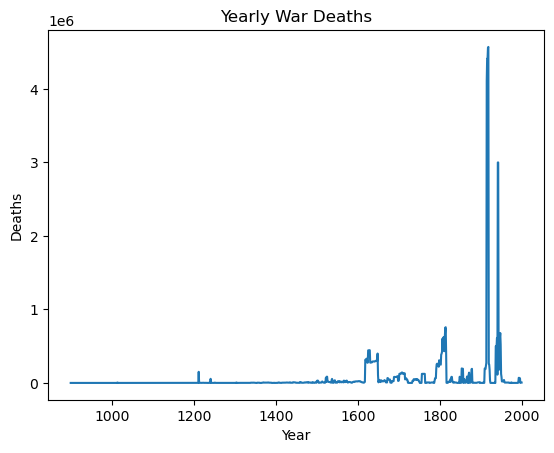

In [ ]:
# Load the data
post1400 = pd.read_excel('..data/Conflict-Catalog-18-vars.xlsx')
pre1400 = pd.read_excel('..data/Brecke-Pre-1400-European-Conflicts.xlsx')


# Convert StartYear and EndYear to integer if not NaN
post1400['StartYear'] = post1400['StartYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)
post1400['EndYear'] = post1400['EndYear'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)

# Filter Region to be 3 and 4
post1400 = post1400[post1400['Region'].isin([3, 4])]
# Select relevant columns
post1400 = post1400[['TotalFatalities', 'MilFatalities', 'StartYear', 'EndYear']].copy()
pre1400 = pre1400[['Fatalities', 'StartYear', 'EndYear']].copy()

# Fill NaN values in TotalFatalities and MilFatalities with 0
post1400['TotalFatalities'] = post1400['TotalFatalities'].fillna(0)
post1400['MilFatalities'] = post1400['MilFatalities'].fillna(0)
post1400['Deaths'] = post1400['TotalFatalities']

pre1400['Deaths'] = pre1400['Fatalities'].fillna(0)

# Drop TotalFatalities and MilFatalities
post1400 = post1400.drop(columns=['TotalFatalities', 'MilFatalities'])

pre1400 = pre1400.drop(columns=['Fatalities'])

wars = pd.concat([pre1400,post1400])

# Initialize an empty dictionary for tracking deaths per year
death_index = {}

# Populate the index with death counts, ongoing wars, started wars, and total duration
for _, row in wars.iterrows():
    if pd.isna(row['StartYear']) or pd.isna(row['EndYear']):
        continue
    
    year_range = range(int(row['StartYear']), int(row['EndYear']) + 1)
    deaths_per_year = row['Deaths'] / len(year_range)
    duration = len(year_range)
    
    for year in year_range:
        if year in death_index:
            death_index[year]['Deaths'] += deaths_per_year
            death_index[year]['ongoing_wars'] += 1
            if year == row['StartYear']:
                death_index[year]['started_wars'] += 1
                death_index[year]['total_duration'] += duration
        else:
            death_index[year] = {
                'Deaths': deaths_per_year,
                'ongoing_wars': 1,
                'started_wars': 1 if year == row['StartYear'] else 0,
                'total_duration': duration if year == row['StartYear'] else 0
            }

# Convert dictionary to DataFrame
conflict = pd.DataFrame.from_dict(death_index, orient='index').reset_index()

conflict['Death_ratio'] = conflict['Deaths'] / conflict['ongoing_wars']
conflict.rename(columns={'index': 'Year'}, inplace=True)
conflict = conflict.sort_values(by='Year').reset_index(drop=True).fillna(0)

conflict.set_index('Year')['Deaths'].plot()
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.title('Yearly War Deaths')
plt.show()

# Merge

In [20]:
df_total = pd.merge(temp_df, pdsi_df, on=['Year', 'Location']) 
df_total = pd.merge(df_total, precip_df, on=['Year', 'Location'])
df_total = pd.merge(df_total, enso, on=['Year'])
df_total = pd.merge(df_total, jsl, on=['Year'])
df_total = pd.merge(df_total, nao, on=['Year'])
df_total = pd.merge(df_total, avg_df, on=['Year', 'Location'])
df_total = df_total.sort_values(['Location', 'Year'])

df_total = pd.merge(df_total, conflict, on=['Year'], how='left')
df_total[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration', 'Death_ratio']] = df_total[['Deaths', 'ongoing_wars', 'started_wars', 'total_duration', 'Death_ratio']].fillna(0)
df_total['logprice'] = np.log(df_total['Price'])
df_total['logprice'] = df_total['logprice'].replace([np.inf, -np.inf], np.nan)

In [21]:
df_total

,Year,temp_winter,Location,temp_summer,temp_winter_europe,temp_summer_europe,PDSI,PDSI_europe,PDSI_southern,precip_winter,...,NAO_model,Latitude,Longitude,Price,Deaths,ongoing_wars,started_wars,total_duration,Death_ratio,logprice
0,1531,0.589043,Aachen,-0.733638,0.294587,-0.277018,-1.286170,-0.610554,0.131007,2.923444,...,-0.093332,50.77,6.10,0.354260,10680.000000,8.0,4.0,11.0,1335.000000,-1.037724
1,1532,0.104855,Aachen,-0.125121,0.287872,-0.156173,-1.579363,-0.802830,0.599090,7.282158,...,-0.518038,50.77,6.10,0.268030,10100.000000,9.0,4.0,8.0,1122.222222,-1.316656
2,1533,0.117664,Aachen,-0.176631,0.182233,-0.085923,0.256732,-0.121523,-0.563359,6.789146,...,-0.393698,50.77,6.10,0.206210,10100.000000,8.0,2.0,5.0,1262.500000,-1.578860
3,1534,-1.198960,Aachen,1.217084,-0.493989,0.067318,-2.164492,0.032315,-0.552188,-7.547451,...,-0.029984,50.77,6.10,0.221220,5166.666667,10.0,6.0,14.0,516.666667,-1.508598
4,1535,-0.399567,Aachen,-0.254127,-0.277823,-0.216290,-1.493775,0.257483,0.444541,-7.243734,...,0.702188,50.77,6.10,0.182440,3066.666667,10.0,3.0,4.0,306.666667,-1.701334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11339,1796,-0.297896,Évora,-0.320892,0.193317,-0.275994,-1.234623,-0.189498,-1.701765,32.624905,...,0.264401,38.57,-7.91,0.876769,232895.476190,8.0,2.0,3.0,29111.934524,-0.131512
11340,1797,-0.483549,Évora,-0.537723,0.522037,0.063651,-0.834578,-0.283687,-1.153439,-0.925016,...,-0.192043,38.57,-7.91,1.199198,220395.476190,6.0,0.0,0.0,36732.579365,0.181653
11341,1798,-0.264980,Évora,-0.142764,-0.223037,0.377239,-0.643749,-0.201885,-0.366558,-1.258465,...,0.010972,38.57,-7.91,1.063805,308174.476190,6.0,1.0,5.0,51362.412698,0.061852
11342,1799,-0.088773,Évora,-0.060273,-0.871053,-0.532169,-0.011002,-0.337022,-0.160040,9.892531,...,-0.735349,38.57,-7.91,1.044463,259167.333333,4.0,0.0,0.0,64791.833333,0.043503


# Teleco

In [22]:
# User-specified variables and significance levels
variables = ['PDSI', 'precip_summer', 'precip_winter', 'temp_winter', 'temp_summer']
significance_levels = [0.05, 0.01, 0.10]

# Merge datasets
df_climate = pd.merge(temp_df, pdsi_df, on=['Year', 'Location']) 
df_climate = df_climate[df_climate['Year'] <= 1800]
df_climate = pd.merge(df_climate, precip_df, on=['Year', 'Location'])
df_climate = pd.merge(df_climate, enso, on=['Year'])
df_climate = pd.merge(df_climate, jsl, on=['Year'])

# Initialize result columns
for var in variables:
    for sig in significance_levels:
        colname = f"teleco_{var}_{int(sig*100):02d}"
        df_total[colname] = 0  # default value

# Additional columns for JSL
for sig in significance_levels:
    colname = f"teleco_PDSI_JSL_{int(sig*100):02d}"
    df_total[colname] = 0

# Loop over locations and variables
for Location, group in df_climate.groupby('Location'):
    for var in variables:
        valid_data = group[[var, 'nino34']].dropna()
        if len(valid_data) >= 2:
            corr, pval = pearsonr(valid_data[var], valid_data['nino34'])
            for sig in significance_levels:
                if (pval <= sig):
                    colname = f"teleco_{var}_{int(sig*100):02d}"
                    if var == "PDSI" and sig == 0.05:
                        print(Location, corr)
                    df_total.loc[df_total['Location'] == Location, colname] = 1

    # PDSI vs. JSL correlation
    valid_jsl_data = group[['PDSI', 'JSL']].dropna()
    if len(valid_jsl_data) >= 2:
        corr_jsl, pval_jsl = pearsonr(valid_jsl_data['PDSI'], valid_jsl_data['JSL'])
        for sig in significance_levels:
            if (pval_jsl <= sig):
                colname = f"teleco_PDSI_JSL_{int(sig*100):02d}"
                df_total.loc[df_total['Location'] == Location, colname] = 1

New Castile 0.15164638570601027


In [ ]:
df_total.to_csv("..processed data/price_2023_enso.csv", index=False)